In [1]:
import sklearn.preprocessing as preprocess
import numpy as np
import pandas as pd
from keras import optimizers
import keras.layers as kl
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import spacy
from keras.utils import to_categorical
from spacy.lang.en import English
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_rows', 1000)
from tqdm import tqdm_notebook
from keras.layers import BatchNormalization, Lambda, Concatenate, Dropout, Conv1D, MaxPooling1D, Input, TimeDistributed, Dense, LSTM, RepeatVector, GlobalAveragePooling1D
from keras.models import Model
import pickle
from datetime import datetime
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from AttentionModules import SelfAttention, CrossAttention
import sys,os
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn import preprocessing
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Using TensorFlow backend.


In [2]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

In [3]:
dnf300 = pd.read_json('evaluation_set/deepnofakes/dnf_300/combined_300.json').T
dnf_eval = pd.read_json('evaluation_set/deepnofakes/Evaluation_Final_50_V4.json')
# display(dnf_eval.head(2))
dnf_eval.columns = ['authors','claim_ids', 'evidence', 'headline', 'id', 'reason', 'claims', 'type', 'urls'] 
with open('evaluation_set/deepnofakes/dnf_300/cleaned/cleaned_dnf300_sent_array_id.p', 'rb') as fp:
    articles = pickle.load(fp)
with open('evaluation_set/deepnofakes/dnf_300/cleaned/cleaned_dnf300_sent_vector_array_id.p', 'rb') as fp:
    article_vectors = pickle.load(fp)
with open('evaluation_set/word_mapping/id_word_mapping.p', 'rb') as fp:
    id_word_mapping = pickle.load(fp)
dnf_eval.keys(), dnf300.keys(), len(articles.keys()), len(article_vectors.keys())

(Index(['authors', 'claim_ids', 'evidence', 'headline', 'id', 'reason',
        'claims', 'type', 'urls'],
       dtype='object'),
 Index(['authors', 'evidence', 'headline', 'id', 'reason', 'type', 'urls'], dtype='object'),
 300,
 300)

In [4]:
num_splits = 5
kf = KFold(n_splits=num_splits)
train_batchsize = 32
val_batchsize = 32
test_batchsize = 50
train_steps_per_epoch = 4
val_steps_per_epoch = 1
epochs = 2000
max_sentences = 500
# for idx in articles.keys():
#     num = len(articles[idx])
#     if num>=max_sentences:
#         max_sentences = num
        
max_sentences

500

In [5]:
titles = sorted(dnf300.headline.unique())
len(titles)

300

In [6]:
test_titles = sorted(dnf_eval.headline.unique())

In [7]:
titles = sorted(dnf300.headline.unique())
non_test_titles = np.array(list(set(titles)-set(test_titles)))


In [8]:
indices = []
for train_index, val_index in kf.split(non_test_titles):
    indices.append([train_index,val_index])

In [9]:

train_index, val_index = indices[np.random.randint(0,num_splits)]
print(train_index,val_index)
val_titles = non_test_titles[val_index]
train_titles = non_test_titles[train_index]
len(train_titles),len(val_titles),len(test_titles)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202] [203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220
 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238
 239 240 241 242 243 244 245 

(203, 50, 50)

In [10]:
def load_spacy():
    sentencizer = English()
    sentencizer.add_pipe(sentencizer.create_pipe('sentencizer'))
    nlp = spacy.load("en_core_web_md")
    return sentencizer, nlp
sentencizer, nlp = load_spacy()


In [11]:

def datagen_dnf(batchsize,dataframe,mode):
    counter=0
    ar_ids,ar_sents,ar_head_vectors,ar_head_classes,hds,ar_claims, ar_sentences=[],[],[],[],[],[],[]
    while True:
        if mode=='train':
            idx=np.random.choice(train_titles)
        elif mode=='val':
            idx=np.random.choice(val_titles)
        elif mode=='test':
            idx=np.random.choice(test_titles)
        idx = idx.strip()
        
            
#         cl = dataframe[dataframe.Article==idx]['Claim'].values
#         sentences=articles[ar_id]
#         print(len(sentences))
        if mode=='test':
            hd = dnf_eval[dnf_eval.headline==idx]['headline'].values[0].lower()
            ar_id = dnf_eval[dnf_eval.headline==idx]['id'].values[0]
            cl = dnf_eval[dnf_eval.headline==idx]['claim_ids'].values[0]
            ar_claims.append(cl)
            
        else:
            try:
                hd = dataframe[dataframe.headline==idx]['headline'].values[0].lower()
                ar_id = dataframe[dataframe.headline==idx]['id'].values[0]
                ar_claims.append('None')
            except Exception as ex:
                print(ex)
                print(idx)
        sentences = articles[ar_id]
        vectors = article_vectors[ar_id]
        hds.append(hd)
        ar_sentences.append(sentences)
#         print(len(sentences))
        sents = np.zeros((max_sentences,300))
        
        sents[:len(vectors)] = vectors
        ar_ids.append(ar_id)
        ar_sents.append(sents)
        hd_nlp = nlp(hd.lower())
        hd_nlp = hd_nlp[:50]
        head_classes = np.zeros(50, dtype='int')
        for i in range(len(hd_nlp)):
            head_classes[i] = hd_nlp[i].rank
        ar_head_vectors.append(hd_nlp.vector)
        ar_head_classes.append(to_categorical(num_classes=20000,y=head_classes))
        counter+=1
        if counter==batchsize:
            inputs = {
                'article_id': np.array(ar_ids)
                ,'headline': np.array(hds)
                ,'sentence_vectors' : np.array(ar_sents)
                ,'input_headline_vector': np.array(ar_head_vectors)
                ,'claims':np.array(ar_claims)
                ,'sentences':np.array(ar_sentences)
            }
            outputs = {
                'headline_token_classes': np.array(ar_head_classes)
                ,'output_headline_vector': np.array(ar_head_vectors)
            }
            yield inputs,outputs
            ar_ids,ar_sents,ar_head_vectors,ar_head_classes,hds,ar_claims, ar_sentences=[],[],[],[],[],[],[]
            counter=0
 

In [12]:
tdg = datagen_dnf(train_batchsize,dnf300,mode='train')
vdg = datagen_dnf(val_batchsize,dnf300,mode='val')
test_dg = datagen_dnf(test_batchsize,dnf300,mode='test')

In [13]:
x,y = next(test_dg)

In [14]:
# x['sentence_vectors'].shape, x['headline_vector'].shape, y['headline_token_classes'].shape

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentence_vectors (InputLayer)   (None, 500, 300)     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 500, 16)      14416       sentence_vectors[0][0]           
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 500, 16)      0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 500, 32)      1568        dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 

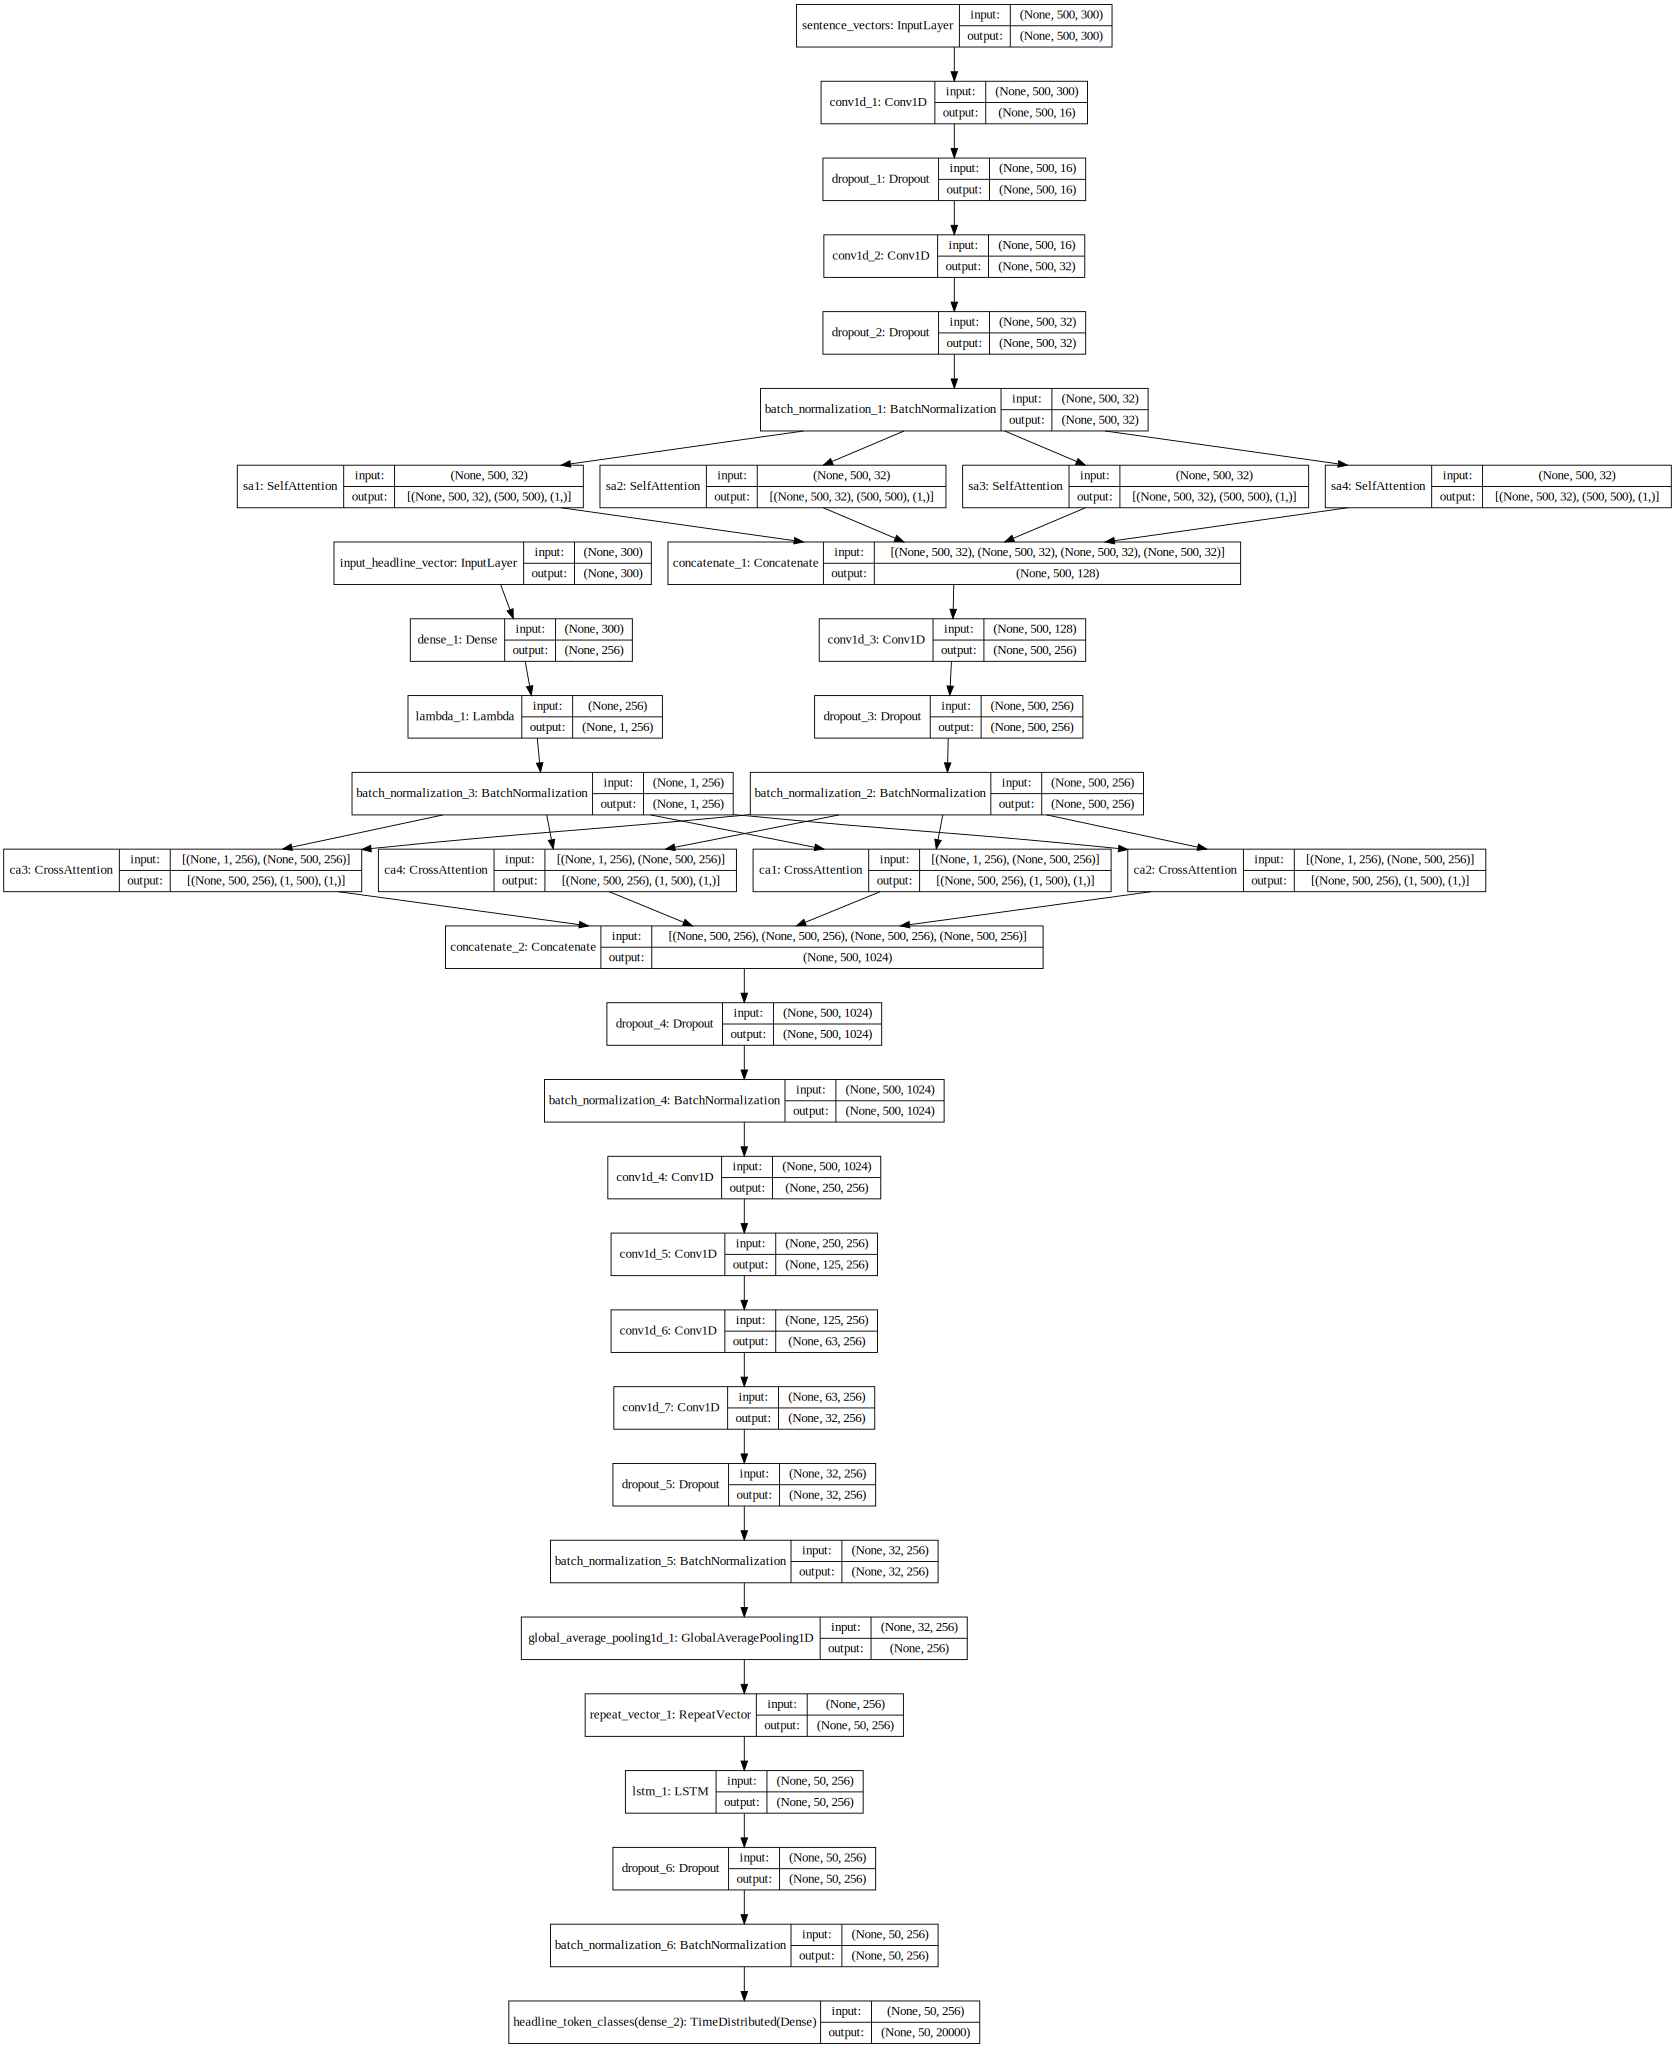

In [15]:
def build_model():
    inp_sentence_vectors = Input(shape=(max_sentences, 300), name='sentence_vectors')
    inp_headline_vector = Input(shape=(300,), name='input_headline_vector')
    conv1 = Conv1D(filters=16,kernel_size=3,strides=1,activation='relu', padding='same')(inp_sentence_vectors)
    conv1 = Dropout(0.5)(conv1)
    conv2 = Conv1D(filters=32,kernel_size=3,strides=1,activation='relu', padding='same')(conv1)
    conv2 = Dropout(0.5)(conv2)
    conv2 = BatchNormalization()(conv2)
    sent_sa_feat_1, sent_beta_1, sent_gamma_1 = SelfAttention(int(conv2.shape[-1]), name = 'sa1')(conv2)
    sent_sa_feat_2, sent_beta_2, sent_gamma_2 = SelfAttention(int(conv2.shape[-1]), name = 'sa2')(conv2)
    sent_sa_feat_3, sent_beta_3, sent_gamma_3 = SelfAttention(int(conv2.shape[-1]), name = 'sa3')(conv2)
    sent_sa_feat_4, sent_beta_4, sent_gamma_4 = SelfAttention(int(conv2.shape[-1]), name = 'sa4')(conv2)
    concat1 = Concatenate()([sent_sa_feat_1,sent_sa_feat_2,sent_sa_feat_3,sent_sa_feat_4])
    conv3 = Conv1D(filters=256,kernel_size=3, strides=1, activation='relu', padding='same')(concat1)
    conv3 = Dropout(0.5)(conv3)
    conv3 = BatchNormalization()(conv3)
    headline = Dense(256, activation='relu')(inp_headline_vector)
    headline = Lambda(lambda x:K.expand_dims(x, axis=1))(headline)
    headline = BatchNormalization()(headline)
    sent_hd_sa_feat_1, sent_hd_beta_1, sent_hd_gamma_1 = CrossAttention(int(conv3.shape[-1]), name = 'ca1')([headline,conv3])
    sent_hd_sa_feat_2, sent_hd_beta_2, sent_hd_gamma_2 = CrossAttention(int(conv3.shape[-1]), name = 'ca2')([headline,conv3])
    sent_hd_sa_feat_3, sent_hd_beta_3, sent_hd_gamma_3 = CrossAttention(int(conv3.shape[-1]), name = 'ca3')([headline,conv3])
    sent_hd_sa_feat_4, sent_hd_beta_4, sent_hd_gamma_4 = CrossAttention(int(conv3.shape[-1]), name = 'ca4')([headline,conv3])  
    concat3 = Concatenate()([sent_hd_sa_feat_1,sent_hd_sa_feat_2,sent_hd_sa_feat_3,sent_hd_sa_feat_4])
    concat3 = Dropout(0.5)(concat3)
    concat3 = BatchNormalization()(concat3)
    conv5 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(concat3)
    conv6 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv5)
    conv7 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv6)
    conv8 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv7)
    conv8 = Dropout(0.5)(conv8)
    conv8 = BatchNormalization()(conv8)
    gap = GlobalAveragePooling1D()(conv8)
    repeat = RepeatVector(50)(gap)
    lstm1 = LSTM(256,return_sequences=True, activation='relu')(repeat)
    lstm1 = Dropout(0.5)(lstm1)
    lstm1 = BatchNormalization()(lstm1)
    gen_hd_vector = TimeDistributed(Dense(20000,activation='softmax'), name='headline_token_classes')(lstm1)
    model = Model([inp_sentence_vectors,inp_headline_vector],gen_hd_vector)
    return model
model = build_model()
model.compile(optimizer=optimizers.Adam(lr=0.0001,beta_1=0.0,beta_2=0.99),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()
# print('model params:',model.count_params())
SVG(model_to_dot(model,show_layer_names=True,show_shapes=True).create(prog='dot', format='svg'))

In [16]:
dt = datetime.now()
mc = ModelCheckpoint('weights/dnf300_sa_sent_hd_word_gl.hdf5',save_best_only=True,save_weights_only=True)
tb = TensorBoard(batch_size=32,log_dir='logs/dnf300_sa_sent_hd_word_gl/{0}'.format(dt.timestamp()),write_graph=True)

In [17]:
hist = model.fit_generator(tdg, callbacks=[mc,tb], initial_epoch=0
                           ,steps_per_epoch=train_steps_per_epoch
                           ,validation_data=vdg
                           ,validation_steps=val_steps_per_epoch
                           ,epochs=epochs)

Epoch 1/2000
4/4 [==============================] - 26s 7s/step - loss: 9.9080 - acc: 0.0000e+00 - val_loss: 9.9093 - val_acc: 0.0000e+00
Epoch 2/2000
4/4 [==============================] - 1s 336ms/step - loss: 9.9060 - acc: 0.0000e+00 - val_loss: 9.8768 - val_acc: 0.0000e+00
Epoch 3/2000
4/4 [==============================] - 1s 335ms/step - loss: 9.8983 - acc: 0.0000e+00 - val_loss: 9.8522 - val_acc: 0.0000e+00
Epoch 4/2000
4/4 [==============================] - 2s 393ms/step - loss: 9.8903 - acc: 0.0000e+00 - val_loss: 9.8183 - val_acc: 0.0000e+00
Epoch 5/2000
4/4 [==============================] - 6s 1s/step - loss: 9.8832 - acc: 0.0011 - val_loss: 9.7706 - val_acc: 0.0000e+00
Epoch 6/2000
4/4 [==============================] - 5s 1s/step - loss: 9.8756 - acc: 0.0028 - val_loss: 9.6923 - val_acc: 0.0000e+00
Epoch 7/2000
4/4 [==============================] - 6s 2s/step - loss: 9.8611 - acc: 0.0037 - val_loss: 9.5561 - val_acc: 0.7350
Epoch 8/2000
4/4 [=============================

4/4 [==============================] - 12s 3s/step - loss: 6.6490 - acc: 0.6734 - val_loss: 7.1490 - val_acc: 0.7156
Epoch 126/2000
4/4 [==============================] - 12s 3s/step - loss: 6.6339 - acc: 0.6781 - val_loss: 7.1092 - val_acc: 0.7150
Epoch 127/2000
4/4 [==============================] - 12s 3s/step - loss: 6.6175 - acc: 0.6686 - val_loss: 7.1191 - val_acc: 0.7138
Epoch 128/2000
4/4 [==============================] - 12s 3s/step - loss: 6.5493 - acc: 0.6705 - val_loss: 7.1076 - val_acc: 0.7113
Epoch 129/2000
4/4 [==============================] - 12s 3s/step - loss: 6.5358 - acc: 0.6600 - val_loss: 6.9412 - val_acc: 0.7144
Epoch 130/2000
4/4 [==============================] - 11s 3s/step - loss: 6.5145 - acc: 0.6683 - val_loss: 6.9676 - val_acc: 0.7188
Epoch 131/2000
4/4 [==============================] - 12s 3s/step - loss: 6.4790 - acc: 0.6713 - val_loss: 7.0416 - val_acc: 0.7244
Epoch 132/2000
4/4 [==============================] - 12s 3s/step - loss: 6.4291 - acc: 0.6

4/4 [==============================] - 14s 4s/step - loss: 3.6325 - acc: 0.7156 - val_loss: 4.1483 - val_acc: 0.7119
Epoch 250/2000
4/4 [==============================] - 15s 4s/step - loss: 3.6408 - acc: 0.7141 - val_loss: 4.1943 - val_acc: 0.7156
Epoch 251/2000
4/4 [==============================] - 16s 4s/step - loss: 3.7221 - acc: 0.6962 - val_loss: 4.1652 - val_acc: 0.7244
Epoch 252/2000
4/4 [==============================] - 16s 4s/step - loss: 3.6085 - acc: 0.7073 - val_loss: 4.2263 - val_acc: 0.7150
Epoch 253/2000
4/4 [==============================] - 15s 4s/step - loss: 3.5299 - acc: 0.7153 - val_loss: 4.0279 - val_acc: 0.7406
Epoch 254/2000
4/4 [==============================] - 15s 4s/step - loss: 3.5157 - acc: 0.7158 - val_loss: 3.9443 - val_acc: 0.7444
Epoch 255/2000
4/4 [==============================] - 15s 4s/step - loss: 3.5167 - acc: 0.7086 - val_loss: 4.1098 - val_acc: 0.7381
Epoch 256/2000
4/4 [==============================] - 16s 4s/step - loss: 3.4688 - acc: 0.7

4/4 [==============================] - 15s 4s/step - loss: 2.2230 - acc: 0.7364 - val_loss: 2.4730 - val_acc: 0.7475
Epoch 374/2000
4/4 [==============================] - 16s 4s/step - loss: 2.2432 - acc: 0.7377 - val_loss: 2.5765 - val_acc: 0.7387
Epoch 375/2000
4/4 [==============================] - 15s 4s/step - loss: 2.2040 - acc: 0.7412 - val_loss: 2.2147 - val_acc: 0.7931
Epoch 376/2000
4/4 [==============================] - 15s 4s/step - loss: 2.1811 - acc: 0.7467 - val_loss: 2.4076 - val_acc: 0.7731
Epoch 377/2000
4/4 [==============================] - 15s 4s/step - loss: 2.2012 - acc: 0.7378 - val_loss: 2.6059 - val_acc: 0.7437
Epoch 378/2000
4/4 [==============================] - 16s 4s/step - loss: 2.2238 - acc: 0.7387 - val_loss: 2.5378 - val_acc: 0.7431
Epoch 379/2000
4/4 [==============================] - 17s 4s/step - loss: 2.1760 - acc: 0.7428 - val_loss: 2.3053 - val_acc: 0.7594
Epoch 380/2000
4/4 [==============================] - 15s 4s/step - loss: 2.1411 - acc: 0.7

4/4 [==============================] - 15s 4s/step - loss: 1.9690 - acc: 0.7342 - val_loss: 2.3251 - val_acc: 0.7394
Epoch 498/2000
4/4 [==============================] - 15s 4s/step - loss: 1.8431 - acc: 0.7495 - val_loss: 2.0081 - val_acc: 0.7594
Epoch 499/2000
4/4 [==============================] - 16s 4s/step - loss: 1.8761 - acc: 0.7439 - val_loss: 2.0874 - val_acc: 0.7569
Epoch 500/2000
4/4 [==============================] - 16s 4s/step - loss: 1.9073 - acc: 0.7353 - val_loss: 2.0354 - val_acc: 0.7725
Epoch 501/2000
4/4 [==============================] - 15s 4s/step - loss: 1.7930 - acc: 0.7562 - val_loss: 1.8128 - val_acc: 0.7881
Epoch 502/2000
4/4 [==============================] - 14s 4s/step - loss: 1.9046 - acc: 0.7359 - val_loss: 2.0714 - val_acc: 0.7638
Epoch 503/2000
4/4 [==============================] - 16s 4s/step - loss: 1.9631 - acc: 0.7250 - val_loss: 2.0932 - val_acc: 0.7475
Epoch 504/2000
4/4 [==============================] - 15s 4s/step - loss: 1.8762 - acc: 0.7

4/4 [==============================] - 15s 4s/step - loss: 1.7430 - acc: 0.7419 - val_loss: 2.1729 - val_acc: 0.7544
Epoch 622/2000
4/4 [==============================] - 14s 4s/step - loss: 1.6691 - acc: 0.7492 - val_loss: 2.2008 - val_acc: 0.7563
Epoch 623/2000
4/4 [==============================] - 16s 4s/step - loss: 1.7887 - acc: 0.7352 - val_loss: 1.9412 - val_acc: 0.7750
Epoch 624/2000
4/4 [==============================] - 16s 4s/step - loss: 1.6828 - acc: 0.7473 - val_loss: 1.9444 - val_acc: 0.7738
Epoch 625/2000
4/4 [==============================] - 15s 4s/step - loss: 1.6857 - acc: 0.7441 - val_loss: 1.7146 - val_acc: 0.8056
Epoch 626/2000
4/4 [==============================] - 12s 3s/step - loss: 1.6652 - acc: 0.7506 - val_loss: 2.0981 - val_acc: 0.7619
Epoch 627/2000
4/4 [==============================] - 15s 4s/step - loss: 1.8304 - acc: 0.7289 - val_loss: 1.8022 - val_acc: 0.7956
Epoch 628/2000
4/4 [==============================] - 16s 4s/step - loss: 1.6466 - acc: 0.7

4/4 [==============================] - 15s 4s/step - loss: 1.6326 - acc: 0.7498 - val_loss: 1.8638 - val_acc: 0.7831
Epoch 746/2000
4/4 [==============================] - 16s 4s/step - loss: 1.6864 - acc: 0.7405 - val_loss: 1.7955 - val_acc: 0.7919
Epoch 747/2000
4/4 [==============================] - 16s 4s/step - loss: 1.6893 - acc: 0.7402 - val_loss: 1.9223 - val_acc: 0.7831
Epoch 748/2000
4/4 [==============================] - 16s 4s/step - loss: 1.6719 - acc: 0.7419 - val_loss: 1.9523 - val_acc: 0.7800
Epoch 749/2000
4/4 [==============================] - 16s 4s/step - loss: 1.5971 - acc: 0.7539 - val_loss: 2.1141 - val_acc: 0.7588
Epoch 750/2000
4/4 [==============================] - 15s 4s/step - loss: 1.7535 - acc: 0.7320 - val_loss: 2.1599 - val_acc: 0.7538
Epoch 751/2000
4/4 [==============================] - 15s 4s/step - loss: 1.6362 - acc: 0.7492 - val_loss: 1.8877 - val_acc: 0.7862
Epoch 752/2000
4/4 [==============================] - 15s 4s/step - loss: 1.6530 - acc: 0.7

4/4 [==============================] - 15s 4s/step - loss: 1.6178 - acc: 0.7403 - val_loss: 2.3870 - val_acc: 0.7450
Epoch 870/2000
4/4 [==============================] - 15s 4s/step - loss: 1.5113 - acc: 0.7537 - val_loss: 2.2528 - val_acc: 0.7544
Epoch 871/2000
4/4 [==============================] - 15s 4s/step - loss: 1.4718 - acc: 0.7561 - val_loss: 2.0244 - val_acc: 0.7738
Epoch 872/2000
4/4 [==============================] - 15s 4s/step - loss: 1.5438 - acc: 0.7452 - val_loss: 1.8866 - val_acc: 0.7931
Epoch 873/2000
4/4 [==============================] - 15s 4s/step - loss: 1.5831 - acc: 0.7455 - val_loss: 2.2839 - val_acc: 0.7431
Epoch 874/2000
4/4 [==============================] - 15s 4s/step - loss: 1.5918 - acc: 0.7433 - val_loss: 1.8455 - val_acc: 0.7956
Epoch 875/2000
4/4 [==============================] - 15s 4s/step - loss: 1.5257 - acc: 0.7580 - val_loss: 2.1661 - val_acc: 0.7812
Epoch 876/2000
4/4 [==============================] - 15s 4s/step - loss: 1.5763 - acc: 0.7

4/4 [==============================] - 16s 4s/step - loss: 1.5945 - acc: 0.7477 - val_loss: 2.0294 - val_acc: 0.7881
Epoch 994/2000
4/4 [==============================] - 15s 4s/step - loss: 1.5442 - acc: 0.7520 - val_loss: 2.5335 - val_acc: 0.7450
Epoch 995/2000
4/4 [==============================] - 15s 4s/step - loss: 1.6095 - acc: 0.7447 - val_loss: 2.0728 - val_acc: 0.7850
Epoch 996/2000
4/4 [==============================] - 15s 4s/step - loss: 1.6233 - acc: 0.7431 - val_loss: 2.2467 - val_acc: 0.7719
Epoch 997/2000
4/4 [==============================] - 16s 4s/step - loss: 1.6496 - acc: 0.7405 - val_loss: 2.3086 - val_acc: 0.7675
Epoch 998/2000
4/4 [==============================] - 15s 4s/step - loss: 1.6425 - acc: 0.7405 - val_loss: 2.1646 - val_acc: 0.7744
Epoch 999/2000
4/4 [==============================] - 16s 4s/step - loss: 1.6005 - acc: 0.7503 - val_loss: 2.2726 - val_acc: 0.7631
Epoch 1000/2000
4/4 [==============================] - 15s 4s/step - loss: 1.5940 - acc: 0.

Epoch 1055/2000
4/4 [==============================] - 15s 4s/step - loss: 1.5343 - acc: 0.7431 - val_loss: 2.2867 - val_acc: 0.7719
Epoch 1056/2000
4/4 [==============================] - 14s 3s/step - loss: 1.5099 - acc: 0.7498 - val_loss: 2.3026 - val_acc: 0.7644
Epoch 1057/2000
4/4 [==============================] - 15s 4s/step - loss: 1.5687 - acc: 0.7423 - val_loss: 2.0655 - val_acc: 0.7862
Epoch 1058/2000
4/4 [==============================] - 14s 4s/step - loss: 1.5418 - acc: 0.7422 - val_loss: 2.3333 - val_acc: 0.7619
Epoch 1059/2000
4/4 [==============================] - 15s 4s/step - loss: 1.5465 - acc: 0.7441 - val_loss: 2.0365 - val_acc: 0.7850
Epoch 1060/2000
4/4 [==============================] - 15s 4s/step - loss: 1.4612 - acc: 0.7544 - val_loss: 2.3116 - val_acc: 0.7675
Epoch 1061/2000
4/4 [==============================] - 16s 4s/step - loss: 1.4721 - acc: 0.7525 - val_loss: 2.5419 - val_acc: 0.7519
Epoch 1062/2000
4/4 [==============================] - 14s 4s/step - 

Epoch 1178/2000
4/4 [==============================] - 15s 4s/step - loss: 1.4514 - acc: 0.7472 - val_loss: 1.9040 - val_acc: 0.7975
Epoch 1179/2000
4/4 [==============================] - 16s 4s/step - loss: 1.4088 - acc: 0.7553 - val_loss: 2.2349 - val_acc: 0.7694
Epoch 1180/2000
4/4 [==============================] - 15s 4s/step - loss: 1.4595 - acc: 0.7491 - val_loss: 2.3487 - val_acc: 0.7581
Epoch 1181/2000
4/4 [==============================] - 15s 4s/step - loss: 1.4671 - acc: 0.7458 - val_loss: 2.4060 - val_acc: 0.7513
Epoch 1182/2000
4/4 [==============================] - 16s 4s/step - loss: 1.4116 - acc: 0.7552 - val_loss: 2.1979 - val_acc: 0.7738
Epoch 1183/2000
4/4 [==============================] - 15s 4s/step - loss: 1.4795 - acc: 0.7484 - val_loss: 2.3269 - val_acc: 0.7556
Epoch 1184/2000
4/4 [==============================] - 16s 4s/step - loss: 1.4023 - acc: 0.7562 - val_loss: 2.0382 - val_acc: 0.7881
Epoch 1185/2000
4/4 [==============================] - 14s 4s/step - 

Epoch 1301/2000
4/4 [==============================] - 15s 4s/step - loss: 1.4688 - acc: 0.7478 - val_loss: 2.7479 - val_acc: 0.7362
Epoch 1302/2000
4/4 [==============================] - 15s 4s/step - loss: 1.4514 - acc: 0.7488 - val_loss: 2.0980 - val_acc: 0.7819
Epoch 1303/2000
4/4 [==============================] - 15s 4s/step - loss: 1.4675 - acc: 0.7431 - val_loss: 2.0141 - val_acc: 0.7875
Epoch 1304/2000
4/4 [==============================] - 15s 4s/step - loss: 1.4827 - acc: 0.7459 - val_loss: 2.1624 - val_acc: 0.7706
Epoch 1305/2000
4/4 [==============================] - 14s 4s/step - loss: 1.4587 - acc: 0.7459 - val_loss: 2.2451 - val_acc: 0.7563
Epoch 1306/2000
4/4 [==============================] - 15s 4s/step - loss: 1.4194 - acc: 0.7534 - val_loss: 2.3530 - val_acc: 0.7462
Epoch 1307/2000
4/4 [==============================] - 14s 4s/step - loss: 1.4987 - acc: 0.7417 - val_loss: 2.5123 - val_acc: 0.7369
Epoch 1308/2000
4/4 [==============================] - 14s 4s/step - 

Epoch 1424/2000
4/4 [==============================] - 15s 4s/step - loss: 1.3660 - acc: 0.7528 - val_loss: 2.2690 - val_acc: 0.7525
Epoch 1425/2000
4/4 [==============================] - 15s 4s/step - loss: 1.5127 - acc: 0.7361 - val_loss: 1.9497 - val_acc: 0.7969
Epoch 1426/2000
4/4 [==============================] - 14s 4s/step - loss: 1.3725 - acc: 0.7477 - val_loss: 1.7967 - val_acc: 0.8169
Epoch 1427/2000
4/4 [==============================] - 15s 4s/step - loss: 1.4214 - acc: 0.7470 - val_loss: 2.2248 - val_acc: 0.7631
Epoch 1428/2000
4/4 [==============================] - 15s 4s/step - loss: 1.3437 - acc: 0.7595 - val_loss: 2.4384 - val_acc: 0.7531
Epoch 1429/2000
4/4 [==============================] - 15s 4s/step - loss: 1.3132 - acc: 0.7622 - val_loss: 2.1104 - val_acc: 0.7881
Epoch 1430/2000
4/4 [==============================] - 15s 4s/step - loss: 1.3251 - acc: 0.7600 - val_loss: 2.1511 - val_acc: 0.7788
Epoch 1431/2000
4/4 [==============================] - 16s 4s/step - 

Epoch 1547/2000
4/4 [==============================] - 15s 4s/step - loss: 1.3611 - acc: 0.7561 - val_loss: 2.1155 - val_acc: 0.7844
Epoch 1548/2000
4/4 [==============================] - 15s 4s/step - loss: 1.3256 - acc: 0.7597 - val_loss: 2.4151 - val_acc: 0.7575
Epoch 1549/2000
4/4 [==============================] - 15s 4s/step - loss: 1.3470 - acc: 0.7567 - val_loss: 2.2705 - val_acc: 0.7713
Epoch 1550/2000
4/4 [==============================] - 15s 4s/step - loss: 1.3800 - acc: 0.7533 - val_loss: 2.3318 - val_acc: 0.7694
Epoch 1551/2000
4/4 [==============================] - 16s 4s/step - loss: 1.4868 - acc: 0.7361 - val_loss: 2.2280 - val_acc: 0.7769
Epoch 1552/2000
4/4 [==============================] - 15s 4s/step - loss: 1.3448 - acc: 0.7572 - val_loss: 2.2500 - val_acc: 0.7825
Epoch 1553/2000
4/4 [==============================] - 15s 4s/step - loss: 1.2559 - acc: 0.7680 - val_loss: 2.4356 - val_acc: 0.7644
Epoch 1554/2000
4/4 [==============================] - 15s 4s/step - 

Epoch 1670/2000
4/4 [==============================] - 15s 4s/step - loss: 1.2402 - acc: 0.7700 - val_loss: 2.3163 - val_acc: 0.7781
Epoch 1671/2000
4/4 [==============================] - 16s 4s/step - loss: 1.3083 - acc: 0.7573 - val_loss: 2.2642 - val_acc: 0.7837
Epoch 1672/2000
4/4 [==============================] - 16s 4s/step - loss: 1.4289 - acc: 0.7427 - val_loss: 2.3521 - val_acc: 0.7638
Epoch 1673/2000
4/4 [==============================] - 15s 4s/step - loss: 1.3964 - acc: 0.7423 - val_loss: 2.8096 - val_acc: 0.7362
Epoch 1674/2000
4/4 [==============================] - 15s 4s/step - loss: 1.3897 - acc: 0.7469 - val_loss: 2.3333 - val_acc: 0.7775
Epoch 1675/2000
4/4 [==============================] - 15s 4s/step - loss: 1.4080 - acc: 0.7498 - val_loss: 2.3637 - val_acc: 0.7731
Epoch 1676/2000
4/4 [==============================] - 16s 4s/step - loss: 1.3575 - acc: 0.7572 - val_loss: 2.3090 - val_acc: 0.7775
Epoch 1677/2000
4/4 [==============================] - 16s 4s/step - 

Epoch 1793/2000
4/4 [==============================] - 15s 4s/step - loss: 1.3536 - acc: 0.7475 - val_loss: 2.3901 - val_acc: 0.7575
Epoch 1794/2000
4/4 [==============================] - 16s 4s/step - loss: 1.3419 - acc: 0.7486 - val_loss: 2.1788 - val_acc: 0.7725
Epoch 1795/2000
4/4 [==============================] - 16s 4s/step - loss: 1.3880 - acc: 0.7427 - val_loss: 2.4670 - val_acc: 0.7519
Epoch 1796/2000
4/4 [==============================] - 16s 4s/step - loss: 1.2634 - acc: 0.7633 - val_loss: 2.1928 - val_acc: 0.7719
Epoch 1797/2000
4/4 [==============================] - 15s 4s/step - loss: 1.3576 - acc: 0.7463 - val_loss: 2.2281 - val_acc: 0.7563
Epoch 1798/2000
4/4 [==============================] - 15s 4s/step - loss: 1.3225 - acc: 0.7541 - val_loss: 2.2594 - val_acc: 0.7694
Epoch 1799/2000
4/4 [==============================] - 15s 4s/step - loss: 1.3809 - acc: 0.7467 - val_loss: 2.3706 - val_acc: 0.7538
Epoch 1800/2000
4/4 [==============================] - 16s 4s/step - 

Epoch 1916/2000
4/4 [==============================] - 16s 4s/step - loss: 1.2844 - acc: 0.7517 - val_loss: 2.1939 - val_acc: 0.7750
Epoch 1917/2000
4/4 [==============================] - 15s 4s/step - loss: 1.2969 - acc: 0.7498 - val_loss: 2.1950 - val_acc: 0.7725
Epoch 1918/2000
4/4 [==============================] - 15s 4s/step - loss: 1.3216 - acc: 0.7448 - val_loss: 2.2346 - val_acc: 0.7650
Epoch 1919/2000
4/4 [==============================] - 15s 4s/step - loss: 1.3383 - acc: 0.7456 - val_loss: 2.3755 - val_acc: 0.7625
Epoch 1920/2000
4/4 [==============================] - 15s 4s/step - loss: 1.2494 - acc: 0.7552 - val_loss: 2.3308 - val_acc: 0.7694
Epoch 1921/2000
4/4 [==============================] - 15s 4s/step - loss: 1.2410 - acc: 0.7572 - val_loss: 2.1980 - val_acc: 0.7844
Epoch 1922/2000
4/4 [==============================] - 13s 3s/step - loss: 1.3531 - acc: 0.7444 - val_loss: 2.1779 - val_acc: 0.7819
Epoch 1923/2000
4/4 [==============================] - 13s 3s/step - 

In [18]:
# from matplotlib import pyplot as plt
# acc = hist.history['acc']
# loss = hist.history['loss']

# # Create count of the number of epochs
# epoch_count = range(1, len(acc) + 1)

# # Visualize loss history
# # plt.plot(epoch_count, acc, 'b-')
# fig, ax = plt.subplots(ncols=2,sharex=True)
# ax[0].plot(epoch_count, loss, 'r--')
# ax[0].legend(['Loss'])
# ax[0].set_xlabel('Epoch')
# ax[0].set_ylabel('Loss')
# ax[1].plot(epoch_count, acc, 'b-')
# ax[1].legend(['Accuracy'])
# ax[1].set_xlabel('Epoch')
# ax[1].set_xlabel('Accuracy')
# plt.show();

In [19]:
# df_res = pd.DataFrame(hist.history)

In [20]:
# df_res[['loss','val_loss']].plot()

In [21]:
# df_res[['acc','val_acc']].plot()

# Evalutate SST

In [22]:
model.load_weights('weights/dnf300_sa_sent_hd_word_gl.hdf5')
model.evaluate_generator(test_dg,steps=5,pickle_safe = True)

/home/mshaikh2/anaconda3/envs/tf-gpu/lib/python3.5/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `evaluate_generator` call to the Keras 2 API: `evaluate_generator(<generator..., use_multiprocessing=True, steps=5)`
  


[2.17778000831604, 0.7424799919128418]

In [23]:
x,y = next(test_dg)
pred = model.predict(x)

In [24]:
# test_idx = np.random.randint(50)
# test_idx

In [25]:
for i in range(len(x['headline'])):
    
    print(i,":",x['article_id'][i],':',x['headline'][i])

0 : 94 : assange confirms: wikileaks didn’t get emails from russian govt
1 : 36 : hillary clinton’s sudden move of $1.8 billion to qatar central bank stuns financial world
2 : 34 : (video) female college students protesting because ‘trump is a rapist’
3 : 28 : he’s never sold an original painting until now…and this one’s going in the white house
4 : 27 : trump accuses obama, hillary clinton of founding daesh
5 : 10 : physician confirms hillary clinton has parkinson's disease
6 : 97 : hillary sold weapons to isis, wikileaks confirms
7 : 13 : hillary clinton in 2013: 'i would like to see people like donald trump run for office
8 : 94 : assange confirms: wikileaks didn’t get emails from russian govt
9 : 7 : hillary clinton used hand signals to rig debate?
10 : 38 : hillary’s (islamic) america is already here where ‘muslim no-go zones’ are popping up all over michiganistan
11 : 91 : us officials see no link between trump and russia
12 : 18 : clinton camp demands 'compliant citizenry' for m

In [26]:
test_idx = 36
x['sentences'][test_idx]


['An intriguing Ministry of Finance (MoF) report circulating in the Kremlin today says that elite Western bankers were “stunned/bewildered” a few hours ago after the Bank For International Settlements (BIS) registered a $1.8 billion transfer from the Clinton Foundation (CF) to the Qatar Central Bank (QCB) through the “facilitation/abetment” of JP Morgan Chase & Company (JPM)—and for reasons yet to be firmly established. [',
 'Note: Some words and/or phrases appearing in quotes in this report are English language approximations of Russian words/phrases having no exact counterpart.]',
 'According to this report, the Bank for International Settlements is the world’s oldest international financial organization and acts as a prime counterparty for central banks in their financial transactions; the Qatar Central Bank is the bank of that Gulf State nations government and their “bank of banks”; JP Morgan Chase & Company is the United States largest “megabank”; and the Clinton Foundation is an 

# Model Test

In [27]:
model_1 = Model(model.inputs,model.get_layer(name='ca1').output)
model_2 = Model(model.inputs,model.get_layer(name='ca2').output)
model_3 = Model(model.inputs,model.get_layer(name='ca3').output)
model_4 = Model(model.inputs,model.get_layer(name='ca4').output)
model_1.summary()
model_2.summary()
model_3.summary()
model_4.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentence_vectors (InputLayer)   (None, 500, 300)     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 500, 16)      14416       sentence_vectors[0][0]           
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 500, 16)      0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 500, 32)      1568        dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 

In [28]:

_, b1, g1 = model_1.predict(x)
_, b2, g2 = model_2.predict(x)
_, b3, g3 = model_3.predict(x)
_, b4, g4 = model_4.predict(x)

In [29]:
# g1,g2,g3,g4

In [30]:
b = b1+b2+b3+b4

In [31]:
best_N = 5
t = b[test_idx][0][:len(x['sentences'][test_idx])].argsort()[-best_N:][::-1]
t

array([2, 3, 1, 0])

In [32]:
print(len(x['sentences'][test_idx]))
b[test_idx][0][:len(x['sentences'][test_idx])].sum()

4


-93.868286

In [33]:
display(x['headline'][test_idx])
display(x['claims'][test_idx])

"hillary clinton's 'sudden move' of $1.8 billion to qatar central bank stuns financial world"

[0, 2, 3]

In [34]:
for s in t:
    if s>=len(x['sentences'][test_idx]):continue
    print(s,':',x['sentences'][test_idx][s])

2 : According to this report, the Bank for International Settlements is the world’s oldest international financial organization and acts as a prime counterparty for central banks in their financial transactions; the Qatar Central Bank is the bank of that Gulf State nations government and their “bank of banks”; JP Morgan Chase & Company is the United States largest “megabank”; and the Clinton Foundation is an international criminal money laundering organization whose clients include the Russian mafia.
3 : With Hillary Clinton’s US presidential campaign Chairman John Podesta having longstanding ties to the Russian mafia and money laundering, this report continues, the Foreign Intelligence Service (SVR) maintains “complete/all times/all ways” surveillance of him and his criminal associates—including both Hillary Clinton and her husband, and former US President, Bill Clinton, and who are collectively designated as the “Clinton Crime Family”.
1 : Note: Some words and/or phrases appearing in

In [35]:
print(len(x['sentences'][test_idx]))
h_s_attended_vector = b[test_idx][0][:len(x['sentences'][test_idx])]
h_s_attended_vector.sum()

4


-93.868286

In [36]:
df_h_s_attended_vector = pd.DataFrame(h_s_attended_vector)


xw = df_h_s_attended_vector.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
xw_scaled = min_max_scaler.fit_transform(xw)
df_h_s_attended_vector = pd.DataFrame(xw_scaled)

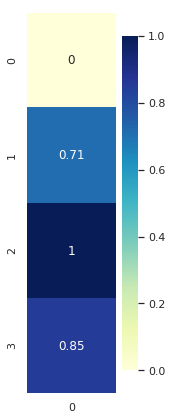

In [37]:
sns.set(rc={'figure.figsize':(2.0,7.0)})
sns.heatmap(df_h_s_attended_vector, annot=True, cmap='YlGnBu', )

# Between Sentences

In [38]:
model_s1 = Model(model.inputs,model.get_layer(name='sa1').output)
model_s2 = Model(model.inputs,model.get_layer(name='sa2').output)
model_s3 = Model(model.inputs,model.get_layer(name='sa3').output)
model_s4 = Model(model.inputs,model.get_layer(name='sa4').output)
model_s1.summary()
model_s2.summary()
model_s3.summary()
model_s4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sentence_vectors (InputLayer (None, 500, 300)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 16)           14416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 500, 32)           1568      
_________________________________________________________________
dropout_2 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 500, 32)           128       
_________________________________________________________________
sa1 (SelfAttention)          [(None, 500, 32), (500, 5 2377      
Total para

In [39]:
_, sb1, sg1 = model_s1.predict([x['sentence_vectors'],x['input_headline_vector']])
_, sb2, sg2 = model_s2.predict(x)
_, sb3, sg3 = model_s3.predict(x)
_, sb4, sg4 = model_s4.predict(x)

In [40]:
sg1,sg2, sg3, sg4

(array([0.00789335, 0.00789335, 0.00789335, 0.00789335, 0.00789335,
        0.00789335, 0.00789335, 0.00789335, 0.00789335, 0.00789335,
        0.00789335, 0.00789335, 0.00789335, 0.00789335, 0.00789335,
        0.00789335, 0.00789335, 0.00789335, 0.00789335, 0.00789335,
        0.00789335, 0.00789335, 0.00789335, 0.00789335, 0.00789335,
        0.00789335, 0.00789335, 0.00789335, 0.00789335, 0.00789335,
        0.00789335, 0.00789335, 0.00789335, 0.00789335, 0.00789335,
        0.00789335, 0.00789335, 0.00789335, 0.00789335, 0.00789335,
        0.00789335, 0.00789335, 0.00789335, 0.00789335, 0.00789335,
        0.00789335, 0.00789335, 0.00789335, 0.00789335, 0.00789335],
       dtype=float32),
 array([0.00588326, 0.00588326, 0.00588326, 0.00588326, 0.00588326,
        0.00588326, 0.00588326, 0.00588326, 0.00588326, 0.00588326,
        0.00588326, 0.00588326, 0.00588326, 0.00588326, 0.00588326,
        0.00588326, 0.00588326, 0.00588326, 0.00588326, 0.00588326,
        0.00588326, 0.00

In [41]:
sb = sb1[test_idx]+sb2[test_idx]+sb3[test_idx]+sb4[test_idx]
sb = sb[:len(x['sentences'][test_idx]),:len(x['sentences'][test_idx])]

sb.shape

(4, 4)

In [42]:
df_sb = pd.DataFrame(sb)


zx = df_sb.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
zx_scaled = min_max_scaler.fit_transform(zx)
df_sb = pd.DataFrame(zx_scaled)

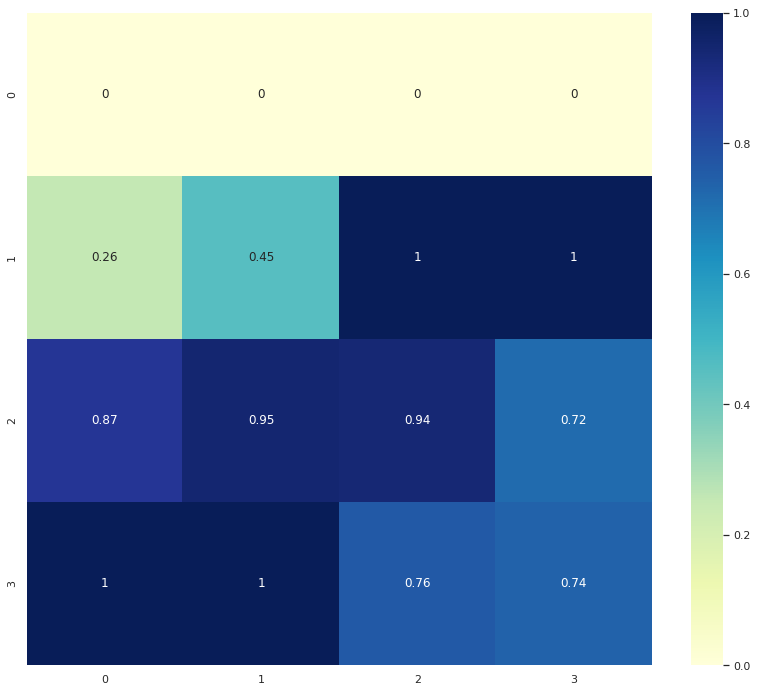

In [43]:
sns.set(rc={'figure.figsize':(14.0,12.0)})
sns.heatmap(pd.DataFrame(df_sb),annot=True,cmap='YlGnBu')

In [44]:
pd.DataFrame(x['sentences'][test_idx])

,0
0,An intriguing Ministry of Finance (MoF) report circulating in the Kremlin today says that elite Western bankers were “stunned/bewildered” a few hours ago after the Bank For International Settlements (BIS) registered a $1.8 billion transfer from the Clinton Foundation (CF) to the Qatar Central Bank (QCB) through the “facilitation/abetment” of JP Morgan Chase & Company (JPM)—and for reasons yet to be firmly established. [
1,Note: Some words and/or phrases appearing in quotes in this report are English language approximations of Russian words/phrases having no exact counterpart.]
2,"According to this report, the Bank for International Settlements is the world’s oldest international financial organization and acts as a prime counterparty for central banks in their financial transactions; the Qatar Central Bank is the bank of that Gulf State nations government and their “bank of banks”; JP Morgan Chase & Company is the United States largest “megabank”; and the Clinton Foundation is an international criminal money laundering organization whose clients include the Russian mafia."
3,"With Hillary Clinton’s US presidential campaign Chairman John Podesta having longstanding ties to the Russian mafia and money laundering, this report continues, the Foreign Intelligence Service (SVR) maintains “complete/all times/all ways” surveillance of him and his criminal associates—including both Hillary Clinton and her husband, and former US President, Bill Clinton, and who are collectively designated as the “Clinton Crime Family”."


In [45]:

def datagen_dnf_eval():

    ar_ids,ar_sents,ar_head_vectors,ar_head_classes,hds,ar_claims, ar_sentences=[],[],[],[],[],[],[]

    for idx in dnf_eval.id: 
        hd = dnf_eval[dnf_eval.id==idx]['headline'].values[0].lower()
        ar_id = dnf_eval[dnf_eval.id==idx]['id'].values[0]
        cl = dnf_eval[dnf_eval.id==idx]['claim_ids'].values[0]
        ar_claims.append(cl)
        sentences = articles[ar_id]
        vectors = article_vectors[ar_id]


        hds.append(hd)
        ar_sentences.append(sentences)
    #         print(len(sentences))
        sents = np.zeros((max_sentences,300))

        sents[:len(vectors)] = vectors
        ar_ids.append(ar_id)
        ar_sents.append(sents)
        hd_nlp = nlp(hd.lower())
        hd_nlp = hd_nlp[:50]
        head_classes = np.zeros(50, dtype='int')
        for i in range(len(hd_nlp)):
            head_classes[i] = hd_nlp[i].rank
        ar_head_vectors.append(hd_nlp.vector)
        ar_head_classes.append(to_categorical(num_classes=20000,y=head_classes))

        inputs = {
            'article_id': np.array(ar_ids)
            ,'headline': np.array(hds)
            ,'sentence_vectors' : np.array(ar_sents)
            ,'input_headline_vector': np.array(ar_head_vectors)
            ,'claims':np.array(ar_claims)
            ,'sentences':np.array(ar_sentences)
        }
        outputs = {
            'headline_token_classes': np.array(ar_head_classes)
            ,'output_headline_vector': np.array(ar_head_vectors)
        }
    return inputs,outputs
testX,testY = datagen_dnf_eval()

In [46]:

best_N = 5
_, b1, g1 = model_1.predict(testX)
_, b2, g2 = model_2.predict(testX)
_, b3, g3 = model_3.predict(testX)
_, b4, g4 = model_4.predict(testX)
ps, rs = [],[]
counter=0
for test_idx in range(len(testX['headline'])):    
    tp,fp,fn = 0,0,0
    claims = np.array(testX['claims'][test_idx])
#     sentences = list(range(len(articles[test_idx])))
    b = b1[test_idx]+b2[test_idx]+b3[test_idx]+b4[test_idx]
    pred = b[0][:len(testX['sentences'][test_idx])].argsort()[-best_N:][::-1]
    
#     print('claims:',claims)
#     print('pred:',pred)
    for p in pred:
        if p in claims:
            tp+=1
        else:
            fp+=1
    for c in claims:
        if c not in pred:
            fn+=1
    p = tp/(tp+fp)
    r = tp/(tp+fn)
#     print()
#     tn = sentences - list(set(list(pred)+list(claims)))
#     print(test_idx,', article id:',x['article_id'][test_idx], ',# sentences:',len(articles[x['article_id'][test_idx]]),":",p,r)
    ps.append(p)
    rs.append(r)
#     counter+=1
#     if counter==5:
#         break
#     print("----------------------------")
#     for s in t:
#         if s>=len(x['sentences'][test_idx]):continue
#         x['sentences'][test_idx][s]
np.average(ps), np.average(rs), 2*np.average(ps)*np.average(rs)/(np.average(ps)+ np.average(rs))

(0.38499999999999995, 0.532, 0.4467175572519083)

In [49]:
df_hd_tp_cdc = pd.read_csv('evaluation_set/cdc_ibm/headline_topic_mapping.csv')
df_ar_cl_cdc = pd.read_csv('evaluation_set/cdc_ibm/article_claim_mapping.csv')
df_hd_tp_dnf = pd.read_json('evaluation_set/deepnofakes/Evaluation_Final_50_V4.json')
df_hd_tp_dnf.columns = ['authors','claim_ids', 'evidence', 'headline', 'id', 'reason', 'claims', 'type', 'urls']
with open('evaluation_set/cdc_ibm/articles.p', 'rb') as fp:
    articles = pickle.load(fp)
with open('evaluation_set/cdc_ibm/article_vectors.p', 'rb') as fp:
    article_vectors = pickle.load(fp)
with open('evaluation_set/word_mapping/id_word_mapping.p', 'rb') as fp:
    id_word_mapping = pickle.load(fp)
df_hd_tp_cdc.keys(),df_ar_cl_cdc.keys(), len(articles.keys()), len(article_vectors.keys()), df_hd_tp_dnf.keys()
test_titles = []
for ar in df_ar_cl_cdc.Article.unique():
    if len(df_ar_cl_cdc[df_ar_cl_cdc.Article==ar]['Claim'].values)>8:
        test_titles.append(ar)
ar_ids,ar_sents,ar_sentences,ar_head_vectors,ar_head_classes,hds,claims=[],[],[],[],[],[],[]
for idx in tqdm_notebook(test_titles):
#     print(idx)
    hd = df_hd_tp_cdc[df_hd_tp_cdc.Title==idx]['Headline'].values[0].lower()
    hds.append(hd)
    ar_id = df_hd_tp_cdc[df_hd_tp_cdc.Title==idx]['article Id'].values[0]
    cl = df_ar_cl_cdc[df_ar_cl_cdc.Article==idx]['Claim'].values
    claims.append(cl)
#     sentences=articles[ar_id]
#     ar_sentences.append(ar_sentences)
    #         print(len(sentences))
    sents = np.zeros((max_sentences,300))
    vectors = article_vectors[ar_id]
    sents[:len(vectors)] = vectors[:max_sentences]
    ar_ids.append(ar_id)
    ar_sents.append(sents)
    hd_nlp = nlp(hd.lower())
    head_classes = np.zeros(50, dtype='int')
    for i in range(len(hd_nlp)):
        head_classes[i] = hd_nlp[i].rank
    ar_head_vectors.append(hd_nlp.vector)
    ar_head_classes.append(to_categorical(num_classes=20000,y=head_classes))
inputs = {
    'article_id': np.array(ar_ids)
    ,'headline': np.array(hds)
    ,'sentence_vectors' : np.array(ar_sents)
#     ,'sentences' : np.array(ar_sentences)
    ,'input_headline_vector': np.array(ar_head_vectors)
    ,'claims':np.array(claims)
}
outputs = {
    'headline_token_classes': np.array(ar_head_classes)
    ,'output_headline_vector': np.array(ar_head_vectors)
}
threshold = 0.95
best_N = 5
_, b1, g1 = model_1.predict(inputs)
_, b2, g2 = model_2.predict(inputs)
_, b3, g3 = model_3.predict(inputs)
_, b4, g4 = model_4.predict(inputs)
ps, rs = [],[]
counter=0
for test_idx in tqdm_notebook(range(len(inputs['headline']))):    
    tp,fp,fn = 0,0,0
    claims = np.array(inputs['claims'][test_idx])
#     sentences = list(range(len(articles[test_idx])))
    b = b1[test_idx]+b2[test_idx]+b3[test_idx]+b4[test_idx]
    ids = b[0][:len(articles[inputs['article_id'][test_idx]])].argsort()[-best_N:][::-1]
#     print(ids)
    pred = np.array(articles[inputs['article_id'][test_idx]])[ids]
#     print('claims:',claims)
#     print('pred:',pred)
    for i in range(len(pred)):
    #     print('===========***********',i,'***********============')
        t5 = nlp(str(pred[i]))
        flag = False
        #pred_claim_sent.append(pred[i])
    #     print(t5.vector)
        for j in range(len(cl)):
            _c = nlp(cl[j])
    #         print(_c.vector)
    #         print('top_5:',t5.text)
    #         print('-------------------')
    #         print('ground_truth:',_c.text)
    #         print('t5:{0}, cl:{1}, sim: {2}'.format(i,j,np.around(t5.similarity(_c),4)))
    #         print('===================================================================')
            if np.around(t5.similarity(_c),4) > threshold:
                tp+=1
                flag = True
                break
        if flag is False:
            fp+=1
        
            
   
    #     print(t5.vector)
    for j in range(len(cl)):
        _c = nlp(cl[j])
        flag = False
        for i in range(len(pred)):
    #     print('===========***********',i,'***********============')
            t5 = nlp(str(pred[i]))
        
    #         print(_c.vector)
    #         print('top_5:',t5.text)
    #         print('-------------------')
    #         print('ground_truth:',_c.text)
    #         print('t5:{0}, cl:{1}, sim: {2}'.format(i,j,np.around(t5.similarity(_c),4)))
    #         print('===================================================================')
            if np.around(t5.similarity(_c),4) > threshold:
                flag = True
                break
        if flag is False:
            fn+=1
         
    p = tp/(tp+fp)
    r = tp/(tp+fn)
#     print()
#     tn = sentences - list(set(list(pred)+list(claims)))
#     print(test_idx,', article id:',x['article_id'][test_idx], ',# sentences:',len(articles[x['article_id'][test_idx]]),":",p,r)
    ps.append(p)
    rs.append(r)

np.average(ps), np.average(rs), 2*np.average(ps)*np.average(rs)/(np.average(ps)+ np.average(rs))

(0.24680851063829795, 0.10813559962496133, 0.150383035067809)